# Inital Benchmark

The purpose of the work on the MNIST dataset is simply to learn how to implement a few new concepts with image analysis and to get a bit more experience developing models with images.

This notebook is designed to get an initial benchmark and feel for the data with a basic CNN.  

Sources
1. https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457
2. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99/notebook


In [2]:
#First importing some relevant packages
import numpy as np
import pandas as pd

#Import Tensorflow
import tensorflow as tf

#Import Keras
import keras
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input, Activation, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.np_utils import to_categorical
from keras.models import load_model

#Import general utilities
import os
import gc
import pickle
import itertools

#import sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

skl_seed = 1234

#Import mathematical functions
from random import *
import math
import matplotlib
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = 'D:/Datasets/MNIST/'
GENERATED_FOLDER = 'D:/Datasets/MNIST/modeldata/'

In [4]:
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
X_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

First do some simple image reshaping and normalization.  This is a very well known dataset so I already know its 10 class multiclass classification with no missing data and pixel intensity values of 0-256, hence extensive EDA is unnecessary.

The only thing I'm doing here is reshaping the images into 4 dimensions as opposed to 3.  This is simply to allow for general n channel models to be used on this data (i.e. keras models).

In [5]:
Y_full = train["label"]

# Drop 'label' column
X_full = train.drop(labels = ["label"],axis = 1) 

# Normalize the data
X_full = X_full / 255.0
X_test = X_test / 255.0

# Reshape image in 4 dimensions (height = 28px, width = 28px , canal = 1)
X_full = X_full.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

del train

gc.collect()

7

Let's take a look at a few images to make sure they make sense.

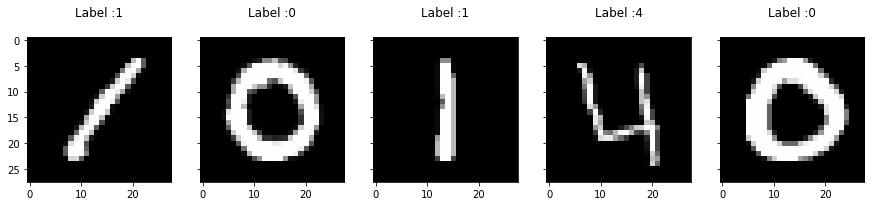

In [5]:
#Observe the data
fig, ax = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(15,15))
for i in range(5):
    ax[i].imshow(X_full[i][:,:,0], cmap='gray')
    ax[i].set_title("Label :{}\n ".format(Y_full[i]))

Double check that the classes are somewhat balanced in the training set.

In [6]:
Y_full.nunique()

10

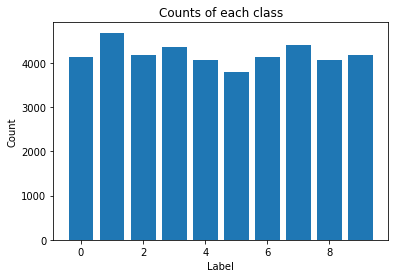

In [7]:
plt.bar(range(10),  Y_full.value_counts(sort=False))
plt.ylabel('Count')
plt.xlabel('Label')
plt.title("Counts of each class")
plt.show()

Now if this was a real competition I would use a k-fold validation scheme and average over each of the k folds for each model trained, however this is not really necessary for this project due to this only being a benchmarking ground for learning some new concepts.

Next lets split our data into training and validation sets.

In [8]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_full, Y_full, test_size=0.1)

print('X_Train shape : ', X_Train.shape)
print('Y_Train shape : ', Y_Train.shape)

X_Train shape :  (37800, 28, 28, 1)
Y_Train shape :  (37800,)


Next let's setup data augmentation and reshape the Y vectors to One Hot encodings.

In [9]:
#Setup data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

#Convert Y vectors to categoricals
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

print(Y_Train[1])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


Now to setup our model.  For a first simple convnet I will use a very basic feedforward convnet with batch normalization and dropout layers.  For now I will not use any residual or inception blocks.

In [16]:
def SimpleModel():
    #Input layer
    X_input = Input((28,28,1))
    
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV Block applied to X
    #X = Conv2D(32, (7, 7), strides = (1, 1), activation='relu', kernel_regularizer="l2")(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    #X = Activation('relu')(X)
    X = MaxPool2D()(X)
    X = Dropout(0.25)(X)
    
    
    #X = Conv2D(64, (5, 5), strides = (1, 1), activation='relu', kernel_regularizer="l2")(X)
    X = Conv2D(64, (5, 5), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    #X = Activation('relu')(X)
    X = MaxPool2D()(X)
    X = Dropout(0.25)(X)

    
    X = Conv2D(128, (3, 3), strides = (1, 1),activation='relu')(X)
    #X = Conv2D(128, (3, 3), strides = (1, 1),activation='relu',  kernel_regularizer="l2")(X)
    #X = BatchNormalization()(X)
    #X = Activation('relu')(X)
    #X = Dropout(0.25)(X)
    
    # MAXPOOL
    #X = MaxPooling2D((3, 3))(X)

    #Convert to vector for final dense layers
    X = Flatten()(X)
    
    #Adding final dense layers
    X = Dense(256, activation='sigmoid')(X)
    X = Dropout(0.25)(X)
    
    
    X = Dense(512, activation='sigmoid')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(10, activation='softmax')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    
    return model

Now to definine the training metrics and instanciate.

In [17]:
start_LR = 0.001
LR_Decay = 0.95

LR_Decayer = LearningRateScheduler(lambda x: start_LR * LR_Decay ** x)

In [18]:
simp_mod = SimpleModel()
simp_mod.compile(optimizer = Adam(start_LR), loss = "binary_crossentropy", metrics = ["accuracy"])

In [19]:
hist = simp_mod.fit_generator(datagen.flow(X_Train, Y_Train, batch_size=8),
                           steps_per_epoch=500,
                           epochs=20,
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(X_Val[:400,:], Y_Val[:400,:]),
                           callbacks=[LR_Decayer])

Epoch 1/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1599 - acc: 0.9459 - val_loss: 0.0436 - val_acc: 0.9853
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0555 - acc: 0.9816 - val_loss: 0.0302 - val_acc: 0.9923
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 0.0386 - acc: 0.9871 - val_loss: 0.0197 - val_acc: 0.9933
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.0337 - acc: 0.9889 - val_loss: 0.0339 - val_acc: 0.9923
Epoch 5/20
500/500 [==============================] - 19s 37ms/step - loss: 0.0305 - acc: 0.9894 - val_loss: 0.0129 - val_acc: 0.9953
Epoch 6/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0230 - acc: 0.9931 - val_loss: 0.0116 - val_acc: 0.9950
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0146 - val_acc: 0.9955
Epoch 8/20
500/500 [==============================] - 18s 36ms

So now the model is trained let's save it for easy recovery and compute some basic stats.

In [7]:
#Save model
simp_mod.save(os.path.join(GENERATED_FOLDER, 'simple_test.pickle'))

#Load model
#simp_mod = load_model(os.path.join(GENERATED_FOLDER, 'simple_test.pickle'))

In [22]:
final_loss, final_acc = simp_mod.evaluate(X_Val, Y_Val, verbose=0)

In [23]:
print('Final Validation Loss = ', final_loss)
print('Final Validation Accuracy = ', final_acc)

Final Validation Loss =  0.006845595737270612
Final Validation Accuracy =  0.9977142810821533


Next let's get the predictions and plot a confusion matrix for the validation set.

In [35]:
Y_hat_val = simp_mod.predict(X_Val)

In [36]:
# Convert predictions classes to one hot vectors 
Y_hat_classes = np.argmax(Y_hat_val, axis = 1) 
# Convert validation observations to one hot vectors
Y_val_classes = np.argmax(Y_Val, axis = 1) 

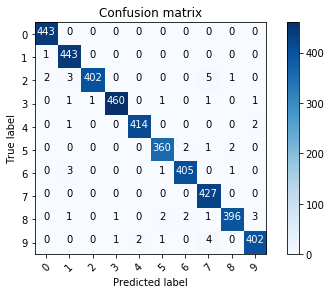

In [46]:
#This code taken almost direct from a source, who attained it from SK Learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val_classes, Y_hat_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Next let's have a look at some of the errors.

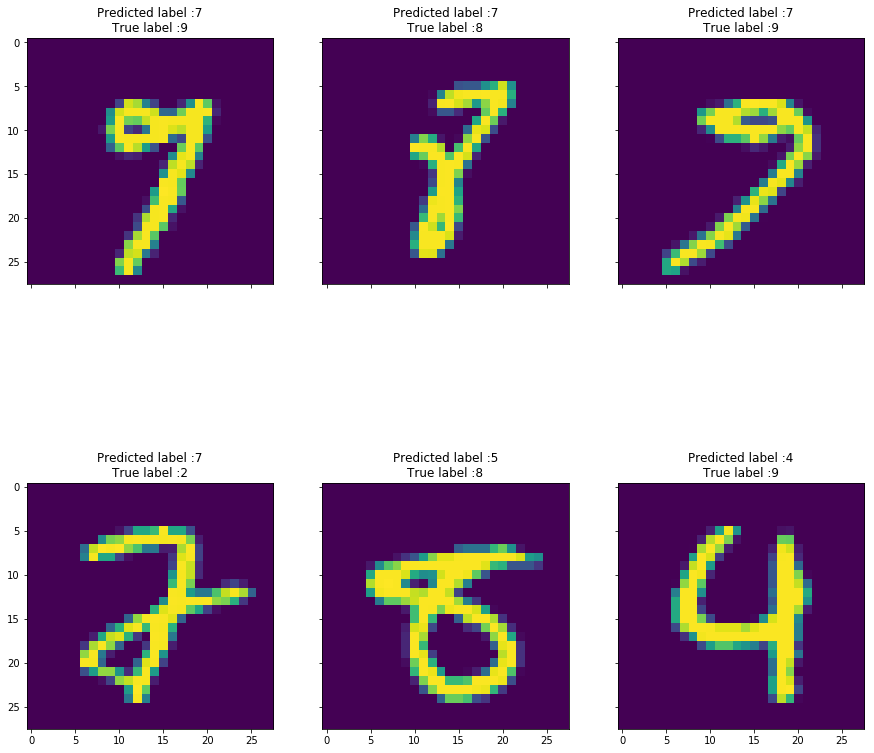

In [66]:
# Display some error results - Code courtesy of aditya soni- Very useful error displayer

# Errors are difference Y_val_classes predicted labels and true labels
errors = (Y_hat_classes - Y_val_classes != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_hat_val[errors]
Y_true_errors = Y_val_classes[errors]
X_val_errors = X_Val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(15,15))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

As a test model this actually worked better than expected.  Let's submit and see how the submission files are formated.

In [17]:
sample_sub = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

In [16]:
y_out = simp_mod.predict(X_test)

In [24]:
Y_out_classes = np.argmax(y_out, axis = 1) 

In [18]:
sample_sub.head(10)

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [26]:
sample_sub['Label'] = Y_out_classes

In [21]:
sample_sub.to_csv('test_mnist_sub.csv', index=False)

Well that about covers the basics. 

However for a first submission the public score I achieved was 98.7%, which given that this model was trained on a tiny subset of the full training set trained for about 20 minutes on CPUs this indicates that this competition may not be great for benchmarking deeper models as it is incredibly easy to learn.

With more training time on GPUs even this model is likely to achieve 99%+ accuracy.

However this will allow me to very quickly and efficiently determine if a neural architecture is poor as if it cannot learn this very simple dataset then it is likely not going to be very useful.